# Maven Power Outage Challenge - Exploratory Data Analysis

For this milestone I will be cleaning and analysing the Maven Analytics "Power Outage Challenge" dataset. 

Electricity outages are a growing concern as we enter an age of unprecedented energy demand and climate disasters. This dataset contains power outage data from across the USA going back to 2002. There are quite a few issues with data quality. 

## Step 0. Understanding the data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium 
import openpyxl

In [ ]:
# Define the sheet names in a list so that we can easily iterate through the excel sheets (tabs). 
# Each sheet contains power outage event data for a single year between 2002 and 2023

sheet_names = [str(n) for n in range(2002, 2024, 1)]

In [ ]:
# Creating a dictionary of pandas dataframes, one dataframe per excel sheet. 
# this will allow us to tailor our data cleaning to the individual sheet since the format of the sheet changes over the years.

DF_dict = {}

for sheet in sheet_names:
    if sheet in ["2002", "2008"]:
        header_value = 2
    else:
        header_value = 1
    
    DF_dict["{0}".format(sheet)] = pd.read_excel('DOE_Electric_Disturbance_Events.xlsx', 
                                                 engine='openpyxl', 
                                                 header=header_value, 
                                                 sheet_name=sheet)

In [ ]:
# We will not use this right now, but the dictionary starting_shapes will help us to 
# understand the data better as we are cleaning

starting_shapes = {}
for sheet in sheet_names:
    starting_shapes[sheet + "_startshape"] = DF_dict[str(sheet)].shape

In [ ]:
# Now lets check out one of the dataframes to see if we get the data we expect:
DF_dict["2008"].head()

The data above is what I expect, however it is very messy! Generally I will need to:
- Make sure columns in each dataframe match (i.e. contain the same feature information)
- Check data within the columns to ensure quality
- Concatenate the source dataframes to create a single dataframe
- Pre-process the data to address inconsistencies before EDA

In [ ]:
# Now lets explore how the column names vary between dataframes. Each row shows the column titles:

column_title_dictionary = {"{0}".format(sheet):DF_dict["{0}".format(sheet)].columns.tolist() for sheet in sheet_names}
column_title_df = pd.DataFrame.from_dict(column_title_dictionary, orient='index') #use the orient argument to make the keys of the dictionary equivalent to the index values of the dataframe
column_title_df

### The target column names

From the dataframe above, we can see that the columns titles make a significant change two times between 2002 - 2023. 

I will approach the data cleaning process slightly differently for each of the three periods: 2002-2010, 2011-2014, 2015-2023

Here are the column names that I will have in the cleaned and concatenated dataframe:
1. "datetime_event_began", 
2. "NERC_region", 
3. "area_affected", 
4. "event_type", 
5. "demand_loss_(MW)", 
6. "number_of_customers_affected", 
7. "datetime_of_restoration"

In [ ]:
post_cleaning_column_titles = ["datetime_event_began", 
                               "NERC_region", 
                               "area_affected", 
                               "event_type", 
                               "demand_loss_(MW)", 
                               "number_of_customers_affected", 
                               "datetime_of_restoration"]

## Step 1. Cleaning the data

### Cleaning dataframes from the years 2002 - 2010:

In [ ]:
# Lets create a function that takes a dataframe, iterates through the rows, and checkes that the "Date" column to a 
# datetime datatype. otherwise it drops the row because this indicates the row is an unexpected format and in this instance 
# most likely a human readable marker.

from datetime import datetime

def drop_non_datetime_values(dataframe_name, column_name):
    for ind, row in dataframe_name.iterrows():
        if type(dataframe_name[column_name][ind]) == datetime:
            pass
        else:
            # print(dataframe_name[column_name][ind]) # I have decided to print out the dropped data to make sure I am not dropping anyting unexpected. 
            dataframe_name.drop(axis=0, index=ind, inplace=True)
    return dataframe_name
           

In [ ]:
# Removing rows from the dataframe that are redundant or that repeat the column names.
for sheet in list(range(2002,2011,1)):
    drop_non_datetime_values(DF_dict["{0}".format(sheet)], "Date")

Now lets focus our attention on the "Time" column

In [ ]:
# We have discovered some "Time" value that can not be changed to a time datatype due to how 
# they have been entered into the database. I will adjust these one-by-one to preserve as much information as possible:

DF_dict["2002"].loc[3, "Time"] = "20:00:00"  # Original value = "Evening"
DF_dict["2003"].loc[56, "Time"] = "15:00:00" # Original value = "Approximately 3:00 p.m."
DF_dict["2003"].loc[78, "Time"] = "12:00:00" # Original value = "12:00 noon"
DF_dict["2004"].loc[3, "Time"] = "00:00:00"  # Original value = "Midnight"
DF_dict["2004"].loc[81, "Time"] = "09:52:00" # Original value = "9: 52 a.m."
DF_dict["2005"].loc[13, "Time"] = "17:28:00" # Original value = "5:78 p.m."
DF_dict["2005"].loc[21, "Time"] = "00:00:00" # Original value = "Midnight"
DF_dict["2006"].loc[12, "Time"] = "00:00:00" # Original value = "Ongoing"

# This is the code I used to find the index value of the problematic time data:
# DataFrame_dict["sheet2006"][DataFrame_dict["sheet2006"]["Time"] == "Ongoing"].index.values[0]

In [ ]:
# Now that the date and time columns are in a format that can be recognised by pd.to_datetime, 
# lets concatenate these two columns

for sheet in list(range(2002,2011,1)):
    DF_dict["{0}".format(sheet)]['Date'] = pd.to_datetime(DF_dict["{0}".format(sheet)]['Date'].astype(str) + ' ' + DF_dict["{0}".format(sheet)]['Time'].astype(str))

In [ ]:
# Now that the time data is included in the first column of our dataframe we can drop the "Time" column 
# from the dataframes containing data for years 2002 - 2010

for sheet in list(range(2002,2011,1)):
    DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop("Time", axis=1)

In [ ]:
# Lets check that the Date column now containes datetimes that include both date and time:
DF_dict["2002"].head()

In [ ]:
DF_dict["2002"].info()

In [ ]:
# Now that dataframes for 2002 - 2010 are fairly clean let us standardise the column names so we can concatenate the dataframes:

for sheet in list(range(2002,2011,1)):
    old_col = DF_dict["{0}".format(sheet)].columns.tolist()
    for n in range(len(post_cleaning_column_titles)):
        DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].rename(columns={old_col[n]: post_cleaning_column_titles[n]})
        
    if len(old_col) > 7: #Drop all additional columns. some sheets had extra columns filled with NaNs
        for x in range(7,len(old_col),1):
            DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop(old_col[x], axis=1)


In [ ]:
DF_dict["2002"].head() #Note, there is still some cleaning to do but we have the dataframe in the general format we want

Next we will transform the "datetime_of_restoration" column into a datetime column which involves 
standardising the format of the date strings before using strptime with a .apply function to change 
the data strings to a recognisable datetime

In [ ]:
# Before we move on to clean the next section of sheets lets 
# create a function that standardises the format of the data in the column titled "datetime_of_restoration". 
# The data in this column has lots of data entry inconsistencies. I will use nested try/ except statements to increase the 
# chance of identifying and parsing the straing into a datetime in an semi-automated way. 
# The date that is still not recognised will be manually changed

def standardise_date_format(date_val):
    if type(date_val) != datetime:
        try:
            date_val = datetime.strptime(str(date_val), "%Y-%m-%d %H:%M:%S")
        except:
            try:
                date_val = datetime.strptime(str(date_val), "%m/%d/%y, %I:%M %p")
            except:
                try:
                    date_val = date_val.strftime("%Y-%m-%d %H:%M:%S")
                    date_val = datetime.strptime(str(date_val), "%Y-%m-%d %H:%M:%S")
                except:
                    try:
                        date_val = datetime.strptime(str(date_val), "%I:%M  %p%B %d%Y")
                    except:
                        try:
                            date_val = datetime.strptime(str(date_val), "%I:%M %p%B %d%Y")
                        except:
                            try:
                                date_val = datetime.strptime(str(date_val), "%I:%M %p %B %d%Y")
                            except:
                                try:
                                    date_val = datetime.strptime(str(date_val), "%I:%M%p%B %d%Y")
                                except:
                                        date_val = None
                    
            
        
    return date_val

In [ ]:
#Adding year to some of the raw data columns so that we can more easily convert to a datetime in a few steps:
DF_dict["2006"]["datetime_of_restoration"] = DF_dict["2006"]["datetime_of_restoration"] + "2006"
DF_dict["2007"]["datetime_of_restoration"] = DF_dict["2007"]["datetime_of_restoration"] + "2007"
DF_dict["2008"]["datetime_of_restoration"] = DF_dict["2008"]["datetime_of_restoration"] + "2008"
DF_dict["2009"]["datetime_of_restoration"] = DF_dict["2009"]["datetime_of_restoration"] + "2009"
DF_dict["2010"]["datetime_of_restoration"] = DF_dict["2010"]["datetime_of_restoration"] + "2010"

In [ ]:
# Individual values in the 2002 "datetime_of_restoration" column that I want to reformat manually:
DF_dict["2002"]["datetime_of_restoration"][24] = datetime(2002, 11, 10, 12, 0, 0)

In [ ]:
# Individual values in the 2003 "datetime_of_restoration" column that I want to reformat manually:

DF_dict["2003"]["datetime_of_restoration"][16] = datetime(2003, 4, 29, 12, 0, 0)
DF_dict["2003"]["datetime_of_restoration"][20] = datetime(2003, 4, 29, 12, 0, 0)
DF_dict["2003"]["datetime_of_restoration"][56] = datetime(2003, 8, 17, 17, 0, 0)
DF_dict["2003"]["datetime_of_restoration"][69] = datetime(2003, 8, 15, 6, 0, 0)
DF_dict["2003"]["datetime_of_restoration"][72] = datetime(2003, 8, 29, 12, 0, 0)
DF_dict["2003"]["datetime_of_restoration"][77] = datetime(2003, 9, 18, 0, 0, 0)
DF_dict["2003"]["datetime_of_restoration"][79] = datetime(2003, 9, 24, 0, 0, 0)
DF_dict["2003"]["datetime_of_restoration"][90] = datetime(2003, 11, 18, 10, 54, 0) 

In [ ]:
# Individual values in the 2004 "datetime_of_restoration" column that I want to reformat manually:
DF_dict["2004"]["datetime_of_restoration"][5] = datetime(2004, 1, 17, 12, 0, 0)
DF_dict["2004"]["datetime_of_restoration"][12] = datetime(2004, 2, 16, 12, 0, 0)
DF_dict["2004"]["datetime_of_restoration"][18] = datetime(2004, 3, 9, 8, 0, 0)
DF_dict["2004"]["datetime_of_restoration"][22] = datetime(2004, 4, 11, 16, 0, 0)
DF_dict["2004"]["datetime_of_restoration"][57] = datetime(2004, 7, 17, 8, 0, 0)
DF_dict["2004"]["datetime_of_restoration"][61] = datetime(2004, 7, 25, 21, 0, 0)
DF_dict["2004"]["datetime_of_restoration"][74] = datetime(2004, 8, 23, 0, 0, 0)
DF_dict["2004"]["datetime_of_restoration"][76] = datetime(2004, 8, 13, 0, 0, 0)
DF_dict["2004"]["datetime_of_restoration"][88] = datetime(2004, 9, 12, 0, 0, 0)
DF_dict["2004"]["datetime_of_restoration"][91] = datetime(2004, 9, 23, 12, 0, 0)
DF_dict["2004"]["datetime_of_restoration"][115] = datetime(2004, 11, 12, 13, 7, 0)

In [ ]:
# Individual values in the 2005 "datetime_of_restoration" column that I want to reformat manually:
DF_dict["2005"]["datetime_of_restoration"][7] = datetime(2005, 1, 23, 11, 24, 0)
DF_dict["2005"]["datetime_of_restoration"][10] = datetime(2005, 1, 31, 10, 0, 0)
DF_dict["2005"]["datetime_of_restoration"][14] = datetime(2005, 2, 15, 13, 30, 0)
DF_dict["2005"]["datetime_of_restoration"][42] = datetime(2005, 6, 20, 17, 15, 0)
DF_dict["2005"]["datetime_of_restoration"][44] = None
DF_dict["2005"]["datetime_of_restoration"][52] = datetime(2005, 7, 11, 17, 33, 0)
DF_dict["2005"]["datetime_of_restoration"][77] = datetime(2005, 9, 8, 0, 1, 0)
DF_dict["2005"]["datetime_of_restoration"][98] = datetime(2005, 10, 2, 17, 0, 0)
DF_dict["2005"]["datetime_of_restoration"][102] = datetime(2005, 10, 18, 15, 37, 0)

In [ ]:
# Individual values in the 2008 "datetime_of_restoration" column that I want to reformat manually:
DF_dict["2008"]["datetime_of_restoration"][57] = datetime(2008, 6, 4, 15, 46, 0)

In [ ]:
for sheet in list(range(2003, 2011, 1)): #NOTE - we do not include 2002 because 2002 does not use am/pm markers
    DF_dict["{0}".format(sheet)]["datetime_of_restoration"] = DF_dict["{0}".format(sheet)]["datetime_of_restoration"].str.replace("a.m.", "AM")
    DF_dict["{0}".format(sheet)]["datetime_of_restoration"] = DF_dict["{0}".format(sheet)]["datetime_of_restoration"].str.replace("p.m.", "PM")
    DF_dict["{0}".format(sheet)]["datetime_of_restoration"] = DF_dict["{0}".format(sheet)]["datetime_of_restoration"].str.replace("PM ", "PM")
    DF_dict["{0}".format(sheet)]["datetime_of_restoration"] = DF_dict["{0}".format(sheet)]["datetime_of_restoration"].str.replace("AM ", "AM")

In [ ]:
for sheet in list(range(2002, 2011, 1)):
    DF_dict["{0}".format(sheet)]["datetime_of_restoration_cleaned"] = DF_dict["{0}".format(sheet)]["datetime_of_restoration"].apply(standardise_date_format)

In [ ]:
# Look at the info() for each dataframe to confirm our new column "datetime_of_restoration_cleaned" contains datetime data:

for sheet in list(range(2002, 2011, 1)):
    txt = "These are the columns for sheet {sheet_name}"
    print(txt.format(sheet_name=sheet), DF_dict["{0}".format(sheet)].info())

### Cleaning dataframes from the years 2011- 2015:

In [ ]:
# Now we will move on to the dataframes that contain data for years 2011 - 2014. Lets look at the dataframe:
DF_dict["2012"].tail(100)

In [ ]:
# Step one, drop values from "Date Event Began" that are not datetime datatypes:
for sheet in list(range(2011,2015,1)):
    drop_non_datetime_values(DF_dict["{0}".format(sheet)], "Date Event Began")

In [ ]:
#Let us make sure the first column contains the date only. initially some cells had date and time values which resulted in an error when I tried to merge columns later on

def date_only(start_year, stop_year, name_of_date_col):
    for sheet in list(range(start_year, stop_year+1, 1)):
        DF_dict["{0}".format(sheet)][name_of_date_col] = pd.to_datetime(DF_dict["{0}".format(sheet)][name_of_date_col]).dt.date
        

In [ ]:
# I also want to make sure the column "Time of restoration" includes only time

# Drop the problematic ongoing row first:
DF_dict["2012"].drop(axis=0, index=146, inplace=True)

DF_dict["2012"]["Time of Restoration"] = pd.to_datetime(DF_dict["2012"]["Time of Restoration"].astype(str)).dt.time

In [ ]:
#Let us make sure the first column contains the date only. 
# Initially some cells had date and time values which resulted in an error when I tried to merge columns later on.

date_only(2011,2014,'Date Event Began')

In [ ]:
DF_dict["2012"].tail(20)

In [ ]:
# Merge date and time information

for sheet in list(range(2011,2015,1)):
    DF_dict["{0}".format(sheet)]['Date Event Began'] = pd.to_datetime(DF_dict["{0}".format(sheet)]['Date Event Began'].astype(str) + ' ' + DF_dict["{0}".format(sheet)]["Time Event Began"].astype(str))

In [ ]:
#Let us make sure the third column contains the date only. initially some cells had date and time values which resulted in an error when I tried to merge columns later on

for sheet in list(range(2011,2015,1)):
    for ind, row in DF_dict["{0}".format(sheet)].iterrows():
        if type(DF_dict["{0}".format(sheet)]['Date of Restoration'][ind]) != datetime:
            DF_dict["{0}".format(sheet)]['Date of Restoration'][ind] = datetime.now().date()
            #DataFrame_dict["sheet{0}".format(sheet)]['Time of Restoration'][ind] = datetime.now().time()
            
        if type(DF_dict["{0}".format(sheet)]['Time of Restoration'][ind]) == str:
            DF_dict["{0}".format(sheet)]['Time of Restoration'][ind] = "00:00:00"
    
    DF_dict["{0}".format(sheet)]['Date of Restoration'] = pd.to_datetime(DF_dict["{0}".format(sheet)]['Date of Restoration']).dt.date
        

In [ ]:
for sheet in list(range(2011,2015,1)):
    DF_dict["{0}".format(sheet)]['Date of Restoration'] = pd.to_datetime(DF_dict["{0}".format(sheet)]['Date of Restoration'].astype(str) + ' ' + DF_dict["{0}".format(sheet)]["Time of Restoration"].astype(str))

In [ ]:
# Now that the "Date Event Began" column and "Date of Restoration" columns include datetime we can drop the "Time Event Began" and "Time of Restoration" columns 
# from the dataframes containing data for years 2011 - 2014

for sheet in list(range(2011,2015,1)):
    DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop(["Time Event Began", "Time of Restoration"], axis=1)

In [ ]:
# Now we need to reorder the columns so they are in the same order as the initial sheets we cleaned.

for sheet in list(range(2011,2015,1)):
    old_col = DF_dict["{0}".format(sheet)].columns.tolist()
    DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)][[old_col[0], old_col[3], old_col[2], old_col[4], old_col[5], old_col[6], old_col[1]]]

In [ ]:
for sheet in list(range(2011,2015,1)):
    old_col = DF_dict["{0}".format(sheet)].columns.tolist()
    for n in range(len(post_cleaning_column_titles)):
        DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].rename(columns={old_col[n]: post_cleaning_column_titles[n]})
        
    if len(old_col) > 7: #Drop all additional columns
        for x in range(7,len(old_col),1):
            DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop(old_col[x], axis=1)

In [ ]:
DF_dict["2014"].head()

In [ ]:
for sheet in list(range(2011, 2015, 1)):
    DF_dict["{0}".format(sheet)]["datetime_of_restoration_cleaned"] = DF_dict["{0}".format(sheet)]["datetime_of_restoration"].apply(standardise_date_format)

In [ ]:
DF_dict["2014"].head()

### Cleaning dataframes from the years 2015- 2023:

In [ ]:
# Now we will move on to the dataframes that contain data for years 2015 - 2023. Lets look at the dataframe:
DF_dict["2018"].head()

In [ ]:
# Drop month column because it is redundant and also drop alert criteria column, we will not be analysing this column this time. 

for sheet in list(range(2015,2024,1)):
    column_titles = DF_dict["{0}".format(sheet)].columns.tolist()
    if "Month" in column_titles:
        DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop(["Month"], axis=1)
    if "Event Month" in column_titles:
        DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop(["Event Month"], axis=1)
    if "Event Year" in column_titles:
        DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop(["Event Year"], axis=1)
    if "Alert Criteria" in column_titles:
        DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop(["Alert Criteria"], axis=1)

In [ ]:
#Let us make sure the first column contains the date only. initially some cells had date and time values which resulted in an error when I tried to merge columns later on

date_only(2015, 2023, "Date Event Began")

In [ ]:
# We have data issues in sheets 2015, 2016, 2017. 
# The issue is that these sheets have many rows of NaNs at the very bottom of the spreadsheet that we need to remove

for sheet in list(range(2015,2024,1)):
    datetime_col = pd.to_datetime(DF_dict["{0}".format(sheet)]['Date Event Began'], errors='coerce')
    print(sheet, datetime_col.isnull().sum())

In [ ]:
# instead of dropping rows that have NaN, how about we keep rows that are not NaN:

for sheet in list(range(2015,2024,1)):
    DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)][DF_dict["{0}".format(sheet)]['Date Event Began'].notna()]

In [ ]:
# The code above has resolved the issues of the NaNs at the very bottom of some of the spreadsheets

for sheet in list(range(2015,2024,1)):
    datetime_col = pd.to_datetime(DF_dict["{0}".format(sheet)]['Date Event Began'], errors='coerce')
    print(sheet, datetime_col.isnull().sum())

In [ ]:
# keep rows that are not "Unknown" 
# (There are a significant number of unknown values that are preventing us from processing the datetime columns properly)

for sheet in list(range(2015,2024,1)):
    DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)][DF_dict["{0}".format(sheet)]['Date of Restoration'].str.strip(" ") !=  "Unknown"]

In [ ]:
# Merge Date Event Began and Time Event Began 

for sheet in list(range(2015,2024,1)):
    DF_dict["{0}".format(sheet)]['Date Event Began'] = pd.to_datetime(DF_dict["{0}".format(sheet)]['Date Event Began'].astype(str) + ' ' + DF_dict["{0}".format(sheet)]["Time Event Began"].astype(str))

In [ ]:
# Now we want to combine the restoration date and restoration time columns. 
# But first we need to get rid of two problematic rows that are missing critical data

DF_dict["2022"].drop(66, axis=0, inplace=True)
DF_dict["2023"].drop(13, axis=0, inplace=True)

In [ ]:
for sheet in list(range(2015,2024,1)):
    DF_dict["{0}".format(sheet)]['Date of Restoration'] = pd.to_datetime(DF_dict["{0}".format(sheet)]['Date of Restoration'].astype(str) + ' ' + DF_dict["{0}".format(sheet)]["Time of Restoration"].astype(str))

In [ ]:
# Now that the "Date Event Began" column and "Date of Restoration" columns include datetime we can drop the "Time Event Began" and "Time of Restoration" columns 
# from the dataframes containing data for years 2011 - 2014

for sheet in list(range(2015,2024,1)):
    DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop(["Time Event Began", "Time of Restoration"], axis=1)

In [ ]:
# Now we need to reorder the columns so they are in the same order as the initial sheets we cleaned.

for sheet in list(range(2015,2024,1)):
    old_col = DF_dict["{0}".format(sheet)].columns.tolist()
    DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)][[old_col[0], old_col[3], old_col[2], old_col[4], old_col[5], old_col[6], old_col[1]]]

In [ ]:
for sheet in list(range(2015,2024,1)):
    old_col = DF_dict["{0}".format(sheet)].columns.tolist()
    for n in range(len(post_cleaning_column_titles)):
        DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].rename(columns={old_col[n]: post_cleaning_column_titles[n]})
        
    if len(old_col) > 7: #Drop all additional columns
        for x in range(7,len(old_col),1):
            DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop(old_col[x], axis=1)

In [ ]:
for sheet in list(range(2015, 2024, 1)):
    DF_dict["{0}".format(sheet)]["datetime_of_restoration_cleaned"] = DF_dict["{0}".format(sheet)]["datetime_of_restoration"].apply(standardise_date_format)

In [ ]:
DF_dict["2016"].info()

### Creating a single dataframe

In [ ]:
# Now that dataframes for 2002 - 2023 are fairly clean and standardised, lets concatenate them:

disturbances = DF_dict["2002"]

for sheet in list(range(2003,2024,1)):
    disturbances = disturbances.append(DF_dict["{0}".format(sheet)], ignore_index=True)

disturbances

In [ ]:
disturbances.info()

## More pre-processing - adjusting the datatypes for easier data manipulation

In [ ]:
## Convert the columns "Datetime_event_began" and "Datetime_of_restoration" to a datetime datatype:

disturbances["datetime_event_began"] = pd.to_datetime(disturbances["datetime_event_began"], format= "%Y-%m-%d %H:%M:%S", utc=True)
disturbances["datetime_event_began"] = disturbances["datetime_event_began"].dt.tz_localize(None)

In [ ]:
# The column "number_of_customers_affected" is currently a string, lets try converting this to an int.

for ind, row in disturbances.iterrows():
    try:
        disturbances["number_of_customers_affected"][ind] = int(disturbances["number_of_customers_affected"][ind])
    except:
        disturbances["number_of_customers_affected"][ind] = None

In [ ]:
# Now lets convert the column "number of customers affected" to an int

disturbances['number_of_customers_affected'] = disturbances['number_of_customers_affected'].fillna(0).astype(int)
disturbances['number_of_customers_affected'] = disturbances['number_of_customers_affected'].astype(str).astype(int)

In [ ]:
# Remove problematic row:
disturbances.drop(axis = 0, index=1357, inplace=True)

In [ ]:
disturbances['demand_loss_(MW)'].iloc[742] = "0"  # Original value = "datetime(2011, 6, 8, 0, 0)"

# We will also convert the column "demand_loss_(MW)" to a float. But first we will replace some values that do not fit the fomat expected:
disturbances['demand_loss_(MW)'] = disturbances['demand_loss_(MW)'].replace({
    "500-600":"500",
    "200-250": "200",
    "75-90":"75",
    "75-90 ":"75",
    "230-300":"230",
    "500-1000":"500",
    "Approx. 18,500 MW, in MISO area:":"18500",
    "18,500":"18500",
    "4,100 MW (Northern NJ) and 400 MW, (Erie,  PA) area":"4500",
    "peak 1655 ":"1655",
    "500-700":"500",
    "Est. 371.1":"370",
    "Est. 75":"75",
    "Approx. 180":"180",
    "Est. 400":"400",
    "Less than 150":"150",
    "Approx. 300":"300",
    "Approx. 30  ":"30",
    "Less than 300":"300",
    "Approx. 100":"100",
    "Approx. 85":"85",
    "133 on 5/21/04  between 3:00 a.m. and 4:00  a.m., 392 on 5/21/04 between 4:00 p.m. and 5:00 p.m.":"525",
    "177 on 5/21/04 between 3:00 p.m. and 5:00 p.m.":"177",
    "60 at peak, ":"60",
    "-":"0",
    "Approx. 200":"200",
    'All':"0",
    "65 to 100":"65",
    "50-60 ":"50",
    "50-100":"50",
    'unknown':"0",
    '  N/A':"0",
    "--":"0",
    "0,":"0",
    "37- 40":"37",
    "100-140":"100",
    "80 to 100":"80",
    "300-500":"300",
    "65-80":"65",
    "8,000-10,000":"8000",
    "800-1,000":"800",
    "8-Jun":"0",
    "900-1000":"900",
    "UNK":"0",
    "Unknown":"0",
    "UNK ":"0",
})

disturbances['demand_loss_(MW)'] = disturbances['demand_loss_(MW)'].fillna(0).astype(int)
disturbances['demand_loss_(MW)'] = disturbances['demand_loss_(MW)'].astype(str).astype(float)

In [ ]:
# There seem to be some NERC codes that have spaces, lets clean these up by removing the spaces:
disturbances["NERC_region"] = disturbances["NERC_region"].str.replace(" ", "")

# We also want to address some naming inconsistencies in the data:
disturbances["NERC_region"] = disturbances["NERC_region"].replace(
    {
        "RF":"RFC",
        "RF/SERC":"SERC/RF",
        "MRO/SERC":"SERC/MRO",
        "RFC;SERC":"SERC/RFC",
        "NPPC":"NPCC",
        "RF/MRO":"MRO/RF",
        "MR0":"MRO",
        "NPCC,RFC":"NPCC/RFC",
        "NPCC;RFC":"NPCC/RFC",
        "RFC,SERC":"SERC/RFC",
        "SPP,SERC,TRE":"SERC/SPP/TRE",
        "NP":"NPCC",
        "MECO":"Other",
        "REC":"Other",
        "HI":"Other",
        "MidwestISO(RFC":"Other",
        "TE":"Other",
        "WeEnergiesMAIN":"Other"
    })

In [ ]:
disturbances.info()

In [ ]:
disturbances["outage_duration"] = disturbances["datetime_of_restoration_cleaned"] - disturbances["datetime_event_began"]

In [ ]:
disturbances.head(10)

In [ ]:
disturbances = disturbances.drop(axis=1, labels="datetime_of_restoration")

In [ ]:
disturbances_condensed = disturbances[["datetime_event_began", "datetime_of_restoration_cleaned", "outage_duration", "NERC_region", "demand_loss_(MW)", "number_of_customers_affected"]]

In [ ]:
disturbances_condensed.head()

#### The features we want to work with ("datetime_event_began", "demand_loss_(MW)", and "number_of_customers_affected") are now in the correct format. EDA can begin!

In [ ]:
# disturbances_condensed.to_csv('disturbances2002_2023_cleaned_condensed.csv')

## Step 3. Exploratory Data Analysis (EDA)

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [3]:
disturbances = pd.read_csv("disturbances2002_2023_cleaned_condensed.csv")

In [6]:
disturbances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3616 entries, 0 to 3615
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype          
---  ------                           --------------  -----          
 0   Unnamed: 0                       3616 non-null   int64          
 1   datetime_event_began             3616 non-null   object         
 2   datetime_of_restoration_cleaned  3579 non-null   object         
 3   outage_duration                  3579 non-null   timedelta64[ns]
 4   NERC_region                      3596 non-null   object         
 5   demand_loss_(MW)                 3616 non-null   float64        
 6   number_of_customers_affected     3616 non-null   int64          
dtypes: float64(1), int64(2), object(3), timedelta64[ns](1)
memory usage: 155.4+ KB


In [31]:
disturbances["outage_duration"].head(60)

0      8 days 06:00:00
1                  NaT
2     11 days 05:00:00
3      0 days 00:47:00
4      2 days 12:00:00
5      0 days 09:00:00
6      0 days 07:27:00
7      0 days 04:39:00
8      0 days 07:32:00
9      0 days 05:53:00
10     0 days 03:50:00
11     0 days 05:36:00
12     0 days 01:29:00
13     8 days 20:27:00
14     3 days 14:00:00
15                 NaT
16     4 days 02:00:00
17     6 days 04:00:00
18     2 days 08:51:00
19     5 days 05:00:00
20     2 days 11:00:00
21     0 days 12:00:00
22     1 days 22:30:00
23     0 days 12:00:00
24     1 days 20:28:00
25     2 days 22:00:00
26     1 days 10:49:00
27     0 days 03:06:00
28                 NaT
29                 NaT
30     0 days 12:00:00
31     0 days 00:37:00
32    32 days 00:00:00
33     1 days 01:48:00
34   -1 days +11:00:00
35                 NaT
36     0 days 02:05:00
37     0 days 04:00:00
38     2 days 07:00:00
39     1 days 21:19:00
40     0 days 04:00:00
41     0 days 06:00:00
42     3 days 12:00:00
43     0 da

In [52]:
def total_seconds(val):
    return val.total_seconds()

disturbances["outage_duration_hours"] = disturbances["outage_duration"].apply(total_seconds) / 3600 

In [61]:
disturbances.shape

(3616, 8)

In [100]:
disturbances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3616 entries, 0 to 3615
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype          
---  ------                           --------------  -----          
 0   Unnamed: 0                       3616 non-null   int64          
 1   datetime_event_began             3616 non-null   datetime64[ns] 
 2   datetime_of_restoration_cleaned  3579 non-null   object         
 3   outage_duration                  3579 non-null   timedelta64[ns]
 4   NERC_region                      3596 non-null   object         
 5   demand_loss_(MW)                 3616 non-null   float64        
 6   number_of_customers_affected     3616 non-null   int64          
 7   outage_duration_hours            3579 non-null   float64        
 8   demand_loss_(MW)_clipped         3616 non-null   float64        
 9   outage_duration_hours_clipped    3579 non-null   float64        
dtypes: datetime64[ns](1), float64(4), int64(2), obje

In [60]:
temp = disturbances[disturbances["outage_duration_hours"] >= 0]
temp.head(50)
temp.shape

(3518, 8)

In [99]:
disturbances["datetime_event_began"] = pd.to_datetime(disturbances["datetime_event_began"])
disturbances["outage_duration"] = pd.to_timedelta(disturbances["outage_duration"])
disturbances["outage_duration"] = pd.to_timedelta(disturbances["outage_duration"], unit="hours")

This data exploration will focus on two features from the dataset: NERC Region and Demand Loss (MW). The North American Electric Reliability Corportion (NERC) is concerned about regional weknesses in the energy grid and want to know where to focus their energy if they want to improve energy reliability across their regional portfolio. This analysis is the first step toward understanding where the most powere outage events are happening as well as how much demand loss occers per event. 

### What North American Electric Reliability Corportion (NERC) regions had the most outages from 2002-2023?

In [82]:
# Create a dataframe that defines the NERC Region codes. We will use this as a legend for the figure below.

NERC_region_dict = {"NERC region codes":
    {"MRO": "Midwest Reliability Organisation",
    "NPCC": "Northeast Power Coordinating Council",
    "RFC": "ReliabilityFirst Corporation",
    "SERC": "SERC Reliability Corporation",
    "SPP": "Southwest Power Pool",
    "TRE": "Texas Reliability Entity",
    "WECC": "Western Electricity Coordinating Council",
    "FRCC": "Florida Reliability Coordinating Council",
    "MAPP": "Mid-continent Area Power Pool",
    "HECO": "Hawaiian Electric",
    "MAAC": "Mid-Atlantic Area Council",
    "WSCC": "Western Systems Coordinating Council",
    "MAIN": "Mid-America Interconnected Network",
    "ERCOT": "Electric Reliability Council of Texas",
    "ECAR": "East Central Area Reliability Coordination Agreement",
    "SPP RE": "SPP Regional Entity"}
}

NERC_region_df = pd.DataFrame(NERC_region_dict)

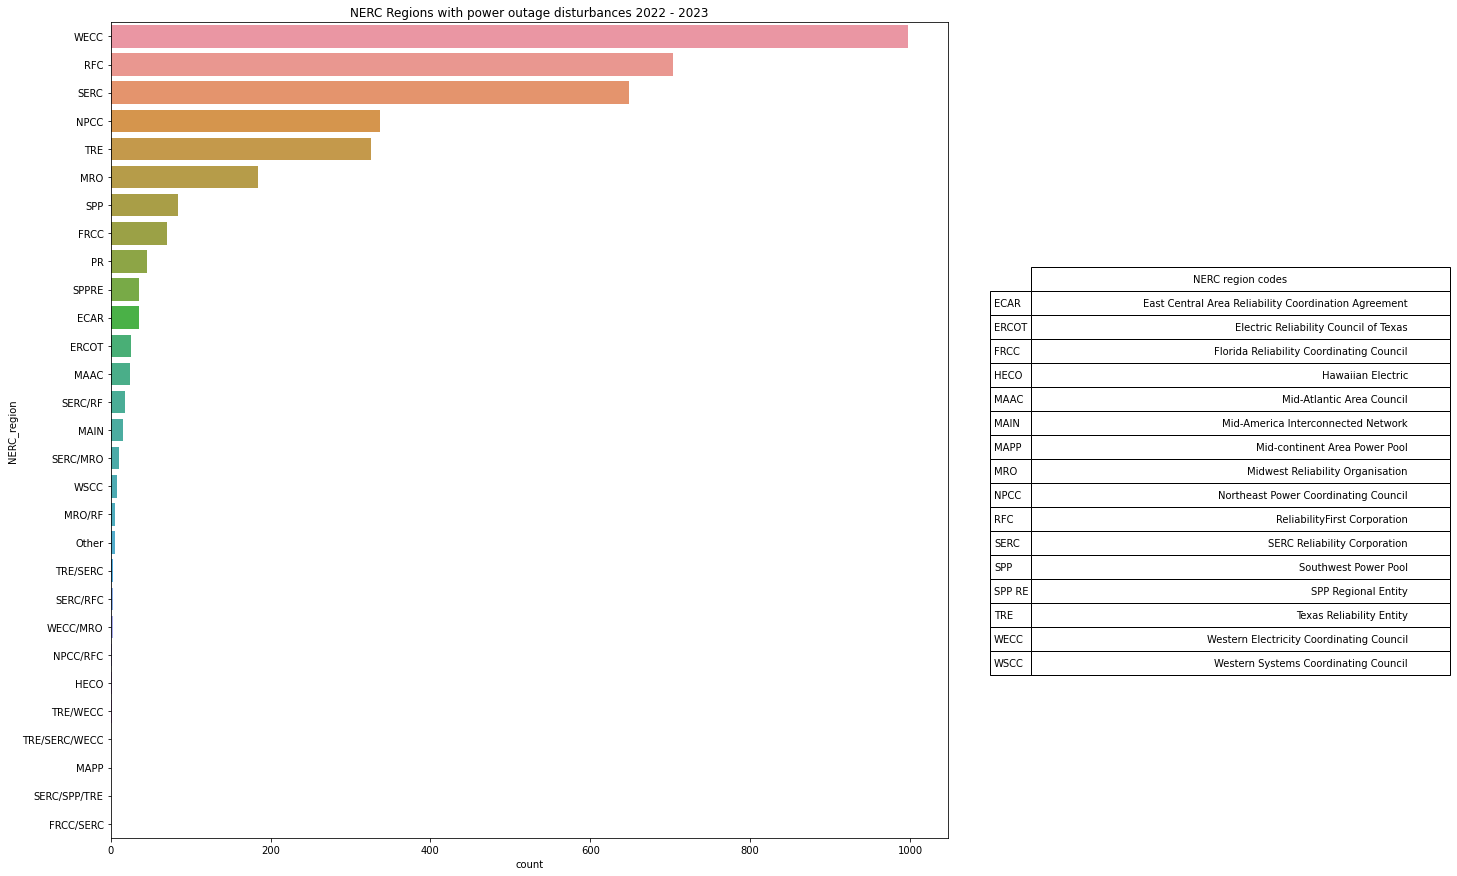

In [83]:
plt.figure(figsize=(15, 15))
sns.countplot(data=disturbances, y='NERC_region', order=disturbances['NERC_region'].value_counts().index, dodge=False)
plt.title("NERC Regions with power outage disturbances 2022 - 2023")

# Add a table to the right of the plot:
Legend_table = plt.table(cellText= NERC_region_df.values,
                        rowLabels= NERC_region_df.index,
                        colLabels= NERC_region_df.columns,
                        bbox=(1.1, .2, 0.5, 0.5))

plt.show()

From the figure above, we can see that the majority of outage events occur in 6-7 NERC regions. It is unclear at this stage whether this has anything to do with sampling bias. More analysis is necessary. My recommendation for NERC is to investigate the following regions more closely to see if there are grid weaknesses that need addressing. These regions had the most outage events from 2002 - 2023:
- Western Electricity Coordinating Council
- Reliability First Corporation
- SERC Reliability Corporation
- Northeast Power Coordinating Council
- Texas Reliability Entity
- Midwest Reliability Reliability Organisation

### How much demand loss (in MW) can be expected in a typical outage event? 

We will look at the regions of interested above and see what the demand loss looks like per region. 

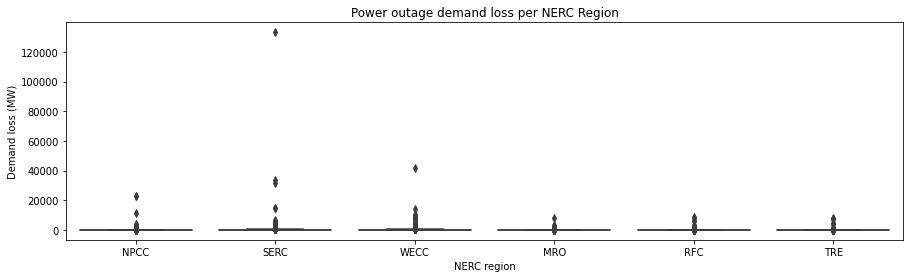

In [85]:
plt.figure(figsize=(15, 4))  #NOTE: Figsize needs to be executed before the boxplot method of else it will not apply
sns.boxplot(
    data=disturbances[disturbances['NERC_region'].isin(["WECC", "RFC", "SERC", "NPCC", "TRE", "MRO"])],
    x='NERC_region',
    y='demand_loss_(MW)'
)

plt.title("Power outage demand loss per NERC Region")
plt.xlabel("NERC region")
plt.ylabel("Demand loss (MW)")
plt.show()

The data above if difficult to understand due to the outliers in the data. lets cap upper and lower bounds so that we can interpret our box plots better.

In [86]:
# Finding IQR:
q3 = disturbances["demand_loss_(MW)"].quantile(0.75)
q1 = disturbances["demand_loss_(MW)"].quantile(0.25)
iqr = q3 - q1 

# Get observations that are greater than 1.5 * iqr:
upper_bound = q3 + (1.5 * iqr)
lower_bound = q1 - (1.5 * iqr)

disturbances["demand_loss_(MW)_clipped"] = np.clip(disturbances["demand_loss_(MW)"], lower_bound, upper_bound)

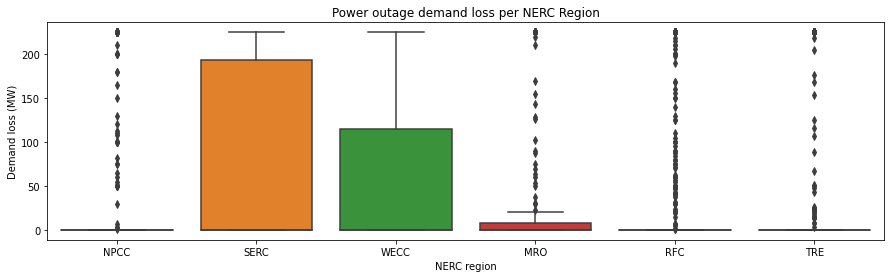

In [87]:
plt.figure(figsize=(15, 4))  #NOTE: Figsize needs to be executed before the boxplot method of else it will not apply
sns.boxplot(
    data=disturbances[disturbances['NERC_region'].isin(["WECC", "RFC", "SERC", "NPCC", "TRE", "MRO"])],
    x='NERC_region',
    y='demand_loss_(MW)_clipped' #Use the clipped data to get rid of outliers
)

plt.title("Power outage demand loss per NERC Region")
plt.xlabel("NERC region")
plt.ylabel("Demand loss (MW)")
plt.show()

In [88]:
# Lets have a closer look at the 6 regions with the most logged disturbances. 

disturbances[disturbances['NERC_region'].isin(["WECC", "RFC", "SERC", "NPCC", "TRE", "MRO"])].groupby(["NERC_region"]).sum()

,Unnamed: 0,demand_loss_(MW),number_of_customers_affected,outage_duration_hours,demand_loss_(MW)_clipped,outage_duration_hours_clipped
NERC_region,,,,,,
MRO,407960,24598.0,6334855,5.955396e+05,6566.0,4623.041667
NPCC,600393,82314.0,24035044,4.855448e+06,9646.0,12620.429167
RFC,1109143,87274.0,70437505,1.082416e+07,25799.0,32485.295833
SERC,1250922,358927.0,47472453,5.143376e+06,44684.0,18789.712500
TRE,788840,52633.0,30890095,1.809845e+06,9972.0,9666.212500
WECC,1917163,321271.0,58510906,9.068390e+06,56628.0,22441.737500


Interesting, the median demand loss for these regions is zero. This does not seem right and means we need to have a closer look at the data. 
- Is demand loss being logged properly? 
- Do we have any negative values that could be skewing the data? 

More analysis needs to take place so that we can answer these questions

### Are there any major outliers in terms of demand loss? What are the features of these outliers?

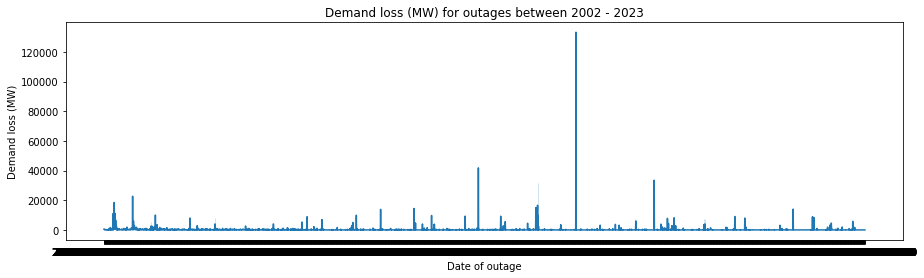

In [89]:
plt.figure(figsize=(15, 4))
sns.lineplot(data=disturbances, x='datetime_event_began', y="demand_loss_(MW)")

plt.title("Demand loss (MW) for outages between 2002 - 2023")
plt.xlabel("Date of outage")
plt.ylabel("Demand loss (MW)")
plt.show()

In [91]:
demand_loss_sorted = disturbances['demand_loss_(MW)'].sort_values(ascending=False)
demand_loss_sorted.head(50)

2244    133200.0
1785     41788.0
2614     33480.0
2062     31500.0
52       22934.0
142      22700.0
47       18500.0
2053     14998.0
1484     14435.0
3279     14000.0
1322     13850.0
55       11202.0
48       11000.0
42       11000.0
249      10000.0
1206      9896.0
2065      9760.0
1566      9750.0
1724      9300.0
1889      9232.0
3000      9000.0
3002      9000.0
975       8881.0
3371      8800.0
3374      8600.0
3378      8250.0
2708      8180.0
535       8087.0
412       8000.0
413       8000.0
3047      8000.0
2675      7800.0
2681      7500.0
2858      7214.0
2847      7214.0
50        7000.0
1044      7000.0
59        6512.0
2528      6062.0
146       6000.0
3559      5800.0
1910      5600.0
950       5299.0
229       5120.0
1190      5000.0
2854      4966.0
1488      4853.0
3459      4615.0
1492      4545.0
54        4500.0
Name: demand_loss_(MW), dtype: float64

In [ ]:
# By sorting the data by demand loss we could get a rough idea about how we want to slice the data to view the events 
# that are responsible for the most demand loss.

disturbances[disturbances["demand_loss_(MW)"] > 10000]

Severe weather seems to be the leading cause of the most disruptive power outages. over 50% of the top 14 outage events (ranked by demand loss) are caused by severe weather. More analysis will need to take place to understand what types of sever weather are most impactful to the energy grid. 

### More Plots - Work in progress

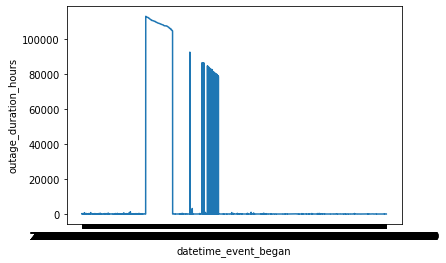

In [65]:
data_subsection = disturbances[disturbances["outage_duration_hours"] >= 0]
sns.lineplot(data=data_subsection, x="datetime_event_began", y="outage_duration_hours")
plt.show()

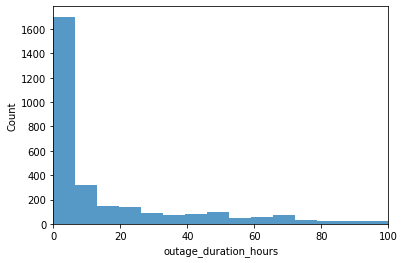

In [69]:
sns.histplot(data=disturbances[disturbances["outage_duration_hours"] >= 0], x="outage_duration_hours")

plt.xlim(0, 100) #We want to focus on this data and not on outliers
plt.show()

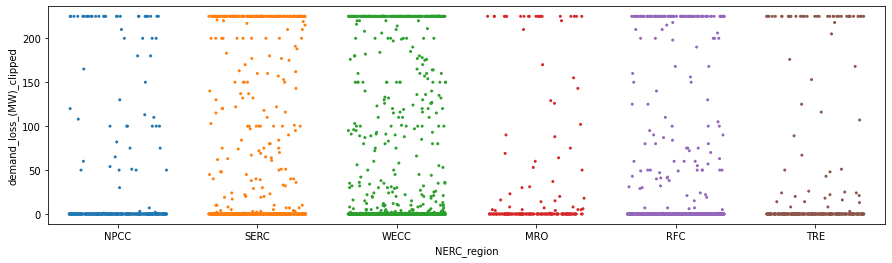

In [73]:
#Lets try a stripplot so that we can visually see how many outages we have for each of the top 6 outage regions
plt.figure(figsize=(15, 4))
sns.stripplot(
    data=disturbances[disturbances['NERC_region'].isin(["WECC", "RFC", "SERC", "NPCC", "TRE", "MRO"])],
    x='NERC_region',
    y='demand_loss_(MW)_clipped', 
    size= 3, 
    jitter=0.35)
plt.show()

In [80]:
# Finding IQR:
q3 = disturbances["outage_duration_hours"].quantile(0.75)
q1 = disturbances["outage_duration_hours"].quantile(0.25)
iqr = q3 - q1 

# Get observations that are greater than 1.5 * iqr:
upper_bound = q3 + (1.5 * iqr)
lower_bound = q1 - (1.5 * iqr)

disturbances["outage_duration_hours_clipped"] = np.clip(disturbances["outage_duration_hours"], 1, upper_bound)

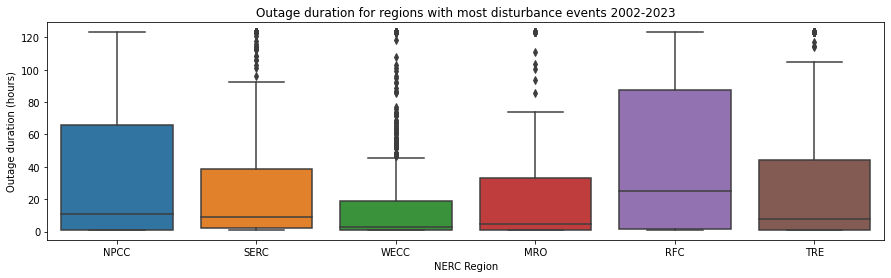

In [84]:
plt.figure(figsize=(15, 4))  #NOTE: Figsize needs to be executed before the boxplot method of else it will not apply
sns.boxplot(
    data=disturbances[disturbances['NERC_region'].isin(["WECC", "RFC", "SERC", "NPCC", "TRE", "MRO"])],
    x='NERC_region',
    y='outage_duration_hours_clipped'
)

plt.title("Outage duration for regions with most disturbance events 2002-2023")
plt.xlabel("NERC Region")
plt.ylabel("Outage duration (hours)")
plt.show()

In [103]:
def get_year(val):
    return val.year

disturbances["year"] = disturbances['datetime_event_began'].apply(get_year)

by_NERC_region = (disturbances
            .groupby(['NERC_region', "year"])
            .size()
            .unstack()
           )
by_NERC_region

year,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
NERC_region,,,,,,,,,,,,,,,,,,,,,
ECAR,1.0,11.0,11.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ERCOT,NaN,3.0,5.0,4.0,8.0,3.0,NaN,NaN,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FRCC,NaN,1.0,19.0,8.0,NaN,NaN,8.0,1.0,NaN,3.0,...,NaN,NaN,5.0,3.0,10.0,1.0,7.0,NaN,NaN,NaN
FRCC/SERC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HECO,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MAAC,2.0,11.0,5.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MAIN,1.0,10.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MAPP,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MRO,NaN,NaN,NaN,2.0,6.0,6.0,3.0,1.0,6.0,4.0,...,22.0,2.0,3.0,4.0,3.0,21.0,25.0,39.0,13.0,13.0


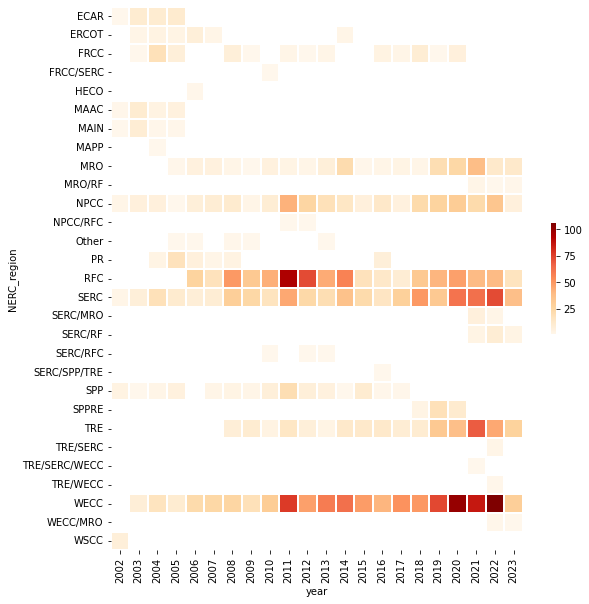

In [107]:
plt.figure(figsize=(10,10))
g = sns.heatmap(
    by_NERC_region, 
    square=True, # make cells square
    cbar_kws={'fraction' : 0.01}, # shrink colour bar
    cmap='OrRd', # use orange/red colour map
    linewidth=1 # space between cells
)

plt.show()

## Step 4 Conclusion and next steps

I spent a lot of time cleaning this data and the EDA I was able to complete by November 27th is a bit limited. I had a lot of fun working with this messy dataset but also have a lot of questions. I know there is a lot to improve. 

Some general notes:
- I wanted to explote the datetime columns more but the data was so messy and I was very stuck on timezones... I abandoned this so that I could at least submit something on time!


Other notes:
- NOTE: I have lost some of the merged cell data from the area column of 2002 sheet, to revisit and look at data dictionary for better understanding
- NOTE: Have i deleted some important data when cleaning my rows that are not datetime data? to review.
- NOTE: when converting the datetime columns to datetime datatypes I set utc=True. This will need to be reviewed.
- NOTE: This is where I found the NERC region code translations: https://www.eia.gov/outlooks/aeo/pdf/nerc_map.pdf